# Titre projet

## Abstract

This study adapts the regime-switching framework of **Yu, Mulvey, and Nie (2025)** to a monthly Fama–French setting. We implement a supervised learning pipeline where the target variable is not an economic state, but the **relative performance of investment factors**.

The pipeline consists of two stages:

1.  **Labeling:** A Jump Model identifies latent periods of persistent outperformance ($r_{\text{factor}} > r_{\text{benchmark}}$) using a penalized segmentation algorithm.
2.  **Forecasting:** We predict these regimes using enriched macroeconomic data (FRED-MD), applying transformations such as EMAs and slopes to capture non-linear market dynamics.

The resulting signals drive a dynamic multi-factor portfolio (**Momentum, Value, Size**). This allocation-focused philosophy prioritizes signal stability and out-of-sample effectiveness by directly targeting asset pricing dynamics rather than general economic conditions.

In [40]:
import os
import random
import re
from io import BytesIO
from itertools import product
from pathlib import Path
from typing import Dict, Optional, Tuple

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import requests
import ruptures as rpt
import seaborn as sns
from fredapi import Fred
from matplotlib.colors import ListedColormap
from numpy.linalg import svd
from PIL import Image
from xgboost import XGBClassifier

from skfin.datasets_ import load_kf_returns
from skfin.metrics import drawdown
from skfin.mv_estimators import Mbj
from skfin.plot import heatmap, line

The **`skfin`** (Scikit-Finance) library serves as a proprietary quantitative finance layer built on top of the standard Python scientific stack (`pandas`, `scikit-learn`, `matplotlib`). It standardizes the research pipeline from data ingestion to portfolio construction.

Based on the codebase analysis, the library is structured around four primary modules:

#### 1. Data Management (`skfin.datasets_`)

This module abstracts the complexity of fetching and cleaning standard financial datasets, ensuring consistent indexing and frequency alignment.

* **Key Function:** `load_kf_returns`
* **Purpose:** Automated ingestion of academic factor data from the **Kenneth French Data Library**. It handles:
    * Date parsing and monthly frequency alignment.
    * Retrieval of Fama-French factors (Mkt-RF, SMB, HML) and Momentum.

#### 2. Risk Metrics (`skfin.metrics`)

Implements vectorized performance and risk indicators essential for strategy evaluation, optimized for `pandas` Series/DataFrames.

* **Key Function:** `drawdown`
* **Definition:** Calculates the percentage decline from a historical peak for a cumulative return series.
    $$DD_t = \frac{W_t}{\max_{s \in [0, t]} W_s} - 1$$
    Where $W_t$ represents the cumulative wealth at time $t$.

#### 3. Financial Visualization (`skfin.plot`)

Provides high-level wrappers around `matplotlib` and `seaborn` to generate standardized, publication-ready financial charts with minimal boilerplate code.

* **`line`:** Specialized for visualizing cumulative wealth curves (growth of $1) with support for logarithmic scales and drawdown shading.
* **`heatmap`:** Optimized for visualizing correlation matrices and regime probabilities.

#### 4. Portfolio Optimization (`skfin.mv_estimators`)

This module constitutes the core of the allocation engine. It provides estimators that adhere to the **Scikit-Learn API** standard (implementing `.fit()` and `.coef_` methods), allowing seamless integration into ML pipelines.

* **Key Estimator:** `Mbj` (**Mean-Bias-J-ratio**)
* **Concept:** Unlike traditional Mean-Variance optimization, which is prone to error maximization (the "Markowitz curse"), the **MBJ estimator** maximizes the Sharpe Ratio while explicitly correcting for the estimation bias inherent in high-dimensional financial data (where $N \approx T$).
* **Optimization Problem:**
    The estimator solves a constrained maximization problem of the form:

    $$w^* = \arg \max_{w} \frac{w^T \hat{\mu} - \lambda \|w\|_2}{ \sqrt{w^T \hat{\Sigma} w} }$$

    $$\text{s.t.} \quad \sum_{i=1}^{N} w_i = 1, \quad w_i \geq 0 \quad (\text{Long-Only})$$

    Where:
    * $\hat{\mu}$ and $\hat{\Sigma}$ are robust estimators of expected returns and covariance.
    * The objective function targets the **J-ratio**, a variation of the information ratio that adjusts for sample size bias.

## I. Data preprocessing

### FRED-MD dataset

To capture the broad macroeconomic environment, we rely on **FRED-MD** (McCracken & Ng, 2016), a large-scale database maintained by the Federal Reserve Bank of St. Louis. This dataset provides a comprehensive monthly timeline of the U.S. economy, covering approximately 128 variables across eight key categories:

* Output and Income
* Labor Market
* Housing
* Consumption & Orders
* Money & Credit
* Interest Rates & Exchange Rates
* Prices
* Stock Market

#### Why FRED-MD?
In a regime-switching framework, asset returns are rarely driven by a single indicator. FRED-MD allows us to extract **high-dimensional features** that capture systemic risk, inflationary pressures, and liquidity cycles. By feeding this rich information set into our XGBoost classifier, we aim to detect subtle shifts in the economic landscape that precede factor rotations.

#### Handling "Ragged Edges"
Real-time macroeconomic data is released with varying lags (e.g., CPI is released later than Interest Rates). This creates a "ragged edge" at the end of the dataset. To prevent **look-ahead bias**, our preprocessing pipeline detects variables with trailing missing values and shifts them forward, ensuring that the model only uses data that would have been actually available to an investor at the time of prediction.

#### Stationarity and Transformations
Each variable in the **FRED-MD** dataset is associated with a *transformation code* (`tcode`), which specifies how the raw series should be transformed before analysis to achieve stationarity and comparability across variables.

The transformation rules, as defined by McCracken and Ng (2016), are as follows:

| Code | Transformation | Description |
|:----:|:------------------------------|:-----------------------------------------------|
| 1 | *No transformation* | Use the level of the series as is |
| 2 | $\Delta x_t$ | First difference of the raw series |
| 3 | $\Delta^2 x_t$ | Second difference of the raw series |
| 4 | $\log(x_t)$ | Natural logarithm of the level |
| 5 | $\Delta \log(x_t)$ | First difference of the logarithm (approximate growth rate) |
| 6 | $\Delta^2 \log(x_t)$ | Second difference of the logarithm |
| 7 | $\Delta \left(\frac{x_t}{x_{t-1}} - 1\right)$ | Change in the growth rate (ratio form) |

These transformations are applied to ensure that most macroeconomic series are **stationary** before being used in empirical models such as factor analysis or forecasting. Variables marked with an asterisk (*) in the FRED-MD documentation indicate that minor adjustments were made relative to their original FRED source.

In [16]:
url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
fred = pd.read_csv(url_data, index_col=0)

# --- Separate transformation "tcodes" (first row) and actual data (remaining rows) ---
fred_data = fred.iloc[1:,:].copy()
fred_code = fred.iloc[0,:].copy()

# --- Convert index to datetime ---
fred_data.index = pd.to_datetime(fred_data.index, infer_datetime_format=True)
print(fred_data.info())

# --- Drop variables with too many missing values ---
cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
fred_data = fred_data.drop(columns=cols_to_drop, errors="ignore").copy()

# --- Function: count consecutive NaN values at the end of a series ---
def trailing_nans(s: pd.Series) -> int:
    """Count the number of consecutive NaN values at the end of a Series."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

# --- Identify variables with trailing NaNs ---
nan_trails = {col: trailing_nans(fred_data[col]) for col in fred_data.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

# --- Shift series forward by 'n' months if they have n trailing NaNs ---
for col, lag in nan_trails.items():
    if lag > 0:
        fred_data[col] = fred_data[col].shift(lag)

# --- Restrict the sample to ensure consistent coverage across variables ---
fred_data = fred_data.loc[fred_data.index >= "1962-05-01"]

print(f"\nFinal dataset size: {fred_data.shape[0]} observations, {fred_data.shape[1]} variables")

# --- Normalize column names to ensure alignment between data and codes ---
fred_data.columns = fred_data.columns.str.upper()

# >>>>> DUPLICATION FEDFUNDS SANS TRANSFORMATION <<<<<
# On crée une seconde colonne FEDFUNCS qui restera en niveau (pas de t-code appliqué)
if "FEDFUNDS" in fred_data.columns:
    fred_data["FEDFUNCS"] = fred_data["FEDFUNDS"]

# fred_code is a single-row DataFrame or a Series with tcodes per column
tcode_map = fred_code.squeeze()                    # to Series if single row
tcode_map.index = tcode_map.index.str.upper()      # align names
tcode_map = pd.to_numeric(tcode_map, errors="coerce")

# --- Container for transformed series ---
df_transformed = pd.DataFrame(index=fred_data.index)

# --- Apply McCracken–Ng tcodes where available; otherwise keep series as is ---
for col in fred_data.columns:
    s = fred_data[col]
    code = tcode_map.get(col, np.nan)  # NaN => no code available

    if pd.isna(code):
        # No transformation code: keep original series (ce sera le cas de FEDFUNCS)
        s_tr = s
    else:
        code = int(code)
        if code == 1:
            s_tr = s
        elif code == 2:
            s_tr = s.diff()
        elif code == 3:
            s_tr = s.diff().diff()
        elif code == 4:
            # Log of levels; guard against non-positive values
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr)
        elif code == 5:
            # First difference of log (approximate growth rate)
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff()
        elif code == 6:
            # Second difference of log
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff().diff()
        else:
            # Δ(x_t / x_{t-1} - 1)
            r = s / s.shift(1) - 1
            s_tr = r.diff()

    df_transformed[col] = s_tr

# List of selected variables
cols_bis = [
    "M2SL",
    "FEDFUNDS",
    "FEDFUNCS",
    "T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM",
    "BAAFFM", "OILPRICEX", "CPIAUCSL",
    "S&P 500", "S&P DIV YIELD", "S&P PE RATIO", "VIXCLSX"
]

# Extract the reduced dataset
df_bis = df_transformed[cols_bis].copy()

# Overview of dimensions and sample rows
print(df_bis.shape)
df_bis.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 1959-01-01 to 2025-08-01
Columns: 126 entries, RPI to VIXCLSx
dtypes: float64(102), int64(24)
memory usage: 793.8 KB
None

Final dataset size: 760 observations, 122 variables
(760, 14)


/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1658/1465958471.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1658/1465958471.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1658/1465958471.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

,M2SL,FEDFUNDS,FEDFUNCS,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,OILPRICEX,CPIAUCSL,S&P 500,S&P DIV YIELD,S&P PE RATIO,VIXCLSX
sasdate,,,,,,,,,,,,,,
1962-05-01,NaN,NaN,2.36,0.67,1.30,1.51,1.92,2.64,NaN,NaN,NaN,NaN,NaN,NaN
1962-06-01,NaN,0.32,2.68,0.35,0.96,1.23,1.60,2.34,NaN,NaN,-0.124253,0.105335,-0.084937,NaN
1962-07-01,-0.000881,0.03,2.71,0.58,1.09,1.30,1.63,2.34,0.0,0.001324,0.023802,0.252174,-0.133255,19.5715
1962-08-01,0.001400,0.22,2.93,0.27,0.78,1.05,1.42,2.13,0.0,0.001653,0.026844,0.443267,0.010199,15.7942
1962-09-01,0.000250,-0.03,2.90,0.16,0.80,1.08,1.42,2.13,0.0,0.002629,-0.008926,-0.075392,0.016086,18.3148


While stationarity transformations are necessary, they remove information regarding the **relative level** and **trend** of the economy. To re-introduce this context and allow the XGBoost classifier to capture non-linear dynamics, we generate a set of enriched features based on strict causal (backward-looking) windows.

#### Rolling Z-Scores (Regime Context)
We normalize each variable against its own recent history using a **12-month rolling window**. This transforms absolute values into relative "regime" indicators (e.g., is inflation high *relative* to the last year?).

$$z_{t} = \frac{x_t - \mu_{(t-11, t)}}{\sigma_{(t-11, t)}}$$

#### Polynomial Features (Non-Linearity)
Asset returns often exhibit non-linear sensitivities to macro factors (e.g., "smile" curves where extreme values on both sides are bearish). We augment the dataset with **squared** ($x^2$) and **cubed** ($x^3$) terms to allow the model's decision trees to approximate these complex boundaries.

#### Trend Indicators (EMA)
To capture momentum and smooth out high-frequency noise, we compute **Exponential Moving Averages (EMA)** with short spans ($s \in \{2, 3, 6\}$ months).

$$\text{EMA}_t(s) = \alpha x_t + (1-\alpha) \text{EMA}_{t-1}(s) \quad \text{where } \alpha = \frac{2}{s+1}$$

#### Structural Dynamics (Slope & Volatility)
We explicitly measure the rate of change and uncertainty using a 12-month rolling window:
* **Rolling Volatility:** Captures the stability of the indicator ($\sigma_t$).
* **Rolling Slope:** We estimate the local linear trend ($\beta$) via OLS to determine if the economy is accelerating or decelerating, regardless of the current level.

$$x_{\tau} = \alpha + \beta \cdot \tau + \epsilon_{\tau} \quad \text{for } \tau \in [t-11, t]$$

#### Final Feature Set
The resulting dataset, `X_macro_enriched`, combines the original transformed series with these derived features. Missing values generated by the rolling windows are handled via forward-filling to preserve data continuity without introducing look-ahead bias.

In [17]:
# Initialization: Create a working copy of the transformed dataset
macro = df_bis.copy()

# Rolling Z-Scores (Regime Context)
# Normalize variables against a 12-month rolling window to capture relative levels.
ROLL_Z = 12
macro_z = (macro - macro.rolling(ROLL_Z).mean()) / macro.rolling(ROLL_Z).std()
macro_z.columns = [c + "_Z" for c in macro.columns]

# Polynomial Features (Non-Linearity)
# Capture convex/concave relationships using squared and cubic terms.
macro_poly2 = macro.pow(2).add_prefix("SQ_")
macro_poly3 = macro.pow(3).add_prefix("CUBE_")

# Exponential Moving Averages (Trend Extraction)
# Compute EMAs with varying spans to filter noise and capture momentum.
EMA_SPANS = [2, 3, 6]
macro_ema = pd.DataFrame(index=macro.index)

for span in EMA_SPANS:
    ema_tmp = macro.ewm(span=span, adjust=False).mean()
    ema_tmp.columns = [f"{c}_EMA{span}" for c in macro.columns]
    macro_ema = pd.concat([macro_ema, ema_tmp], axis=1)

# Volatility & Structural Dynamics
ROLL_WINDOW = 12

# Rolling Volatility (Uncertainty proxy)
macro_rollvol = macro.rolling(ROLL_WINDOW).std().add_prefix("VOL_")

# Rolling Linear Slope (Local Trend)
def rolling_slope(x, window=ROLL_WINDOW):
    """
    Calculates the rolling OLS slope coefficient (beta) over a specified window.
    Acts as a proxy for the local derivative (acceleration/deceleration).
    """
    idx = np.arange(window)
    coefs = []

    for i in range(window, len(x)+1):
        y = x[i-window:i]
        if y.isna().any():
            coefs.append(np.nan)
            continue

        # Slope via OLS closed-form: Cov(x,y) / Var(x)
        beta = np.cov(idx, y)[0,1] / np.var(idx)
        coefs.append(beta)

    return pd.Series([np.nan]*(window-1) + coefs, index=x.index)

macro_slope = pd.DataFrame(index=macro.index)
for c in macro.columns:
    macro_slope[c + "_SLOPE"] = rolling_slope(macro[c])

# Final Assembly
# Concatenate all derived features.
X_macro_enriched = pd.concat([
    macro,          # Original transformed series
    macro_z,        # Z-scores
    macro_poly2,    # Quadratic
    macro_ema,      # EMAs
    macro_slope     # Slopes
], axis=1)

# Forward-fill to propagate the last known values (handling publication lags)
# and drop initial NaNs resulting from rolling windows.
macro = X_macro_enriched.fillna(method="ffill").dropna()

print("Shape enriched macro :", X_macro_enriched.shape)

Shape enriched macro : (760, 98)


### Fama–French style factors

The factor data are sourced from Kenneth French’s Data Library, which provides long-horizon, research-grade monthly time series widely used in empirical asset pricing. The dataset includes five well-known Fama–French style factors: **SMB**, **HML**, **RMW**, **CMA**, and **MOM**, each representing a distinct compensated source of risk in cross-sectional equity returns. **SMB** (Small Minus Big) captures the size premium by measuring the performance spread between small-cap and large-cap stocks. **HML** (High Minus Low) reflects the value premium by comparing returns of high book-to-market firms to low book-to-market firms. **RMW** (Robust Minus Weak) measures the profitability premium, contrasting firms with strong operating profitability against those with weak profitability. **CMA** (Conservative Minus Aggressive) represents the investment premium based on differences in corporate investment policies. Finally, **MOM** (Momentum) captures the well-documented tendency for stocks with strong past performance to continue outperforming in the near term. Together, these factors form a comprehensive framework for explaining and modeling the cross-section of expected equity returns.


In [18]:
# Load Fama-French Data
# Load the standard 3-Factor model (Market, SMB, HML) and the Momentum factor.
ff = load_kf_returns(filename="F-F_Research_Data_Factors")["Monthly"].copy()
mom = load_kf_returns(filename="F-F_Momentum_Factor")["Monthly"].copy()

# Date and Column Cleaning
# Ensure the index is datetime format and remove whitespace from column names.
ff.index  = pd.to_datetime(ff.index,  format="%Y%m")
mom.index = pd.to_datetime(mom.index, format="%Y%m")
ff.columns  = ff.columns.str.strip()
mom.columns = mom.columns.str.strip()

# Dynamically identify the momentum column (handles variations like 'Mom' or 'MOM')
mom_col = [c for c in mom.columns if c.lower().startswith("mom")][0]

# Merging Datasets
# Combine the 3-Factor dataset with Momentum and rename columns for consistency.
factors = (
    ff[["Mkt-RF", "SMB", "HML", "RF"]]
    .join(mom.rename(columns={mom_col: "Momentum"})[["Momentum"]], how="inner")
).rename(columns={
    "SMB":  "Size",
    "HML":  "Value",
})

# Unit Conversion
# Convert returns from percentages (e.g., 5.0) to decimals (e.g., 0.05).
ret_cols = ["Mkt-RF", "Size", "Value", "RF", "Momentum"]
factors[ret_cols] = factors[ret_cols] / 100

# Derived Metrics
# Reconstruct the Total Market Return (Excess Market + Risk-Free Rate).
factors["Mkt"] = factors["Mkt-RF"] + factors["RF"]

# Compute Active Returns (Factor Performance relative to the Market).
# This serves as the basis for the regime identification (Jump Model).
for s in ["Momentum", "Size", "Value"]:
    factors[f"{s}_minus_Mkt"] = factors[s] - factors["Mkt"]

# Sample Selection
# Filter data starting from 1963 to align with standard academic literature.
factors = factors[factors.index >= "1963-01-01"].copy()

print("Facteurs FF+MOM :", factors.shape)

Facteurs FF+MOM : (752, 9)


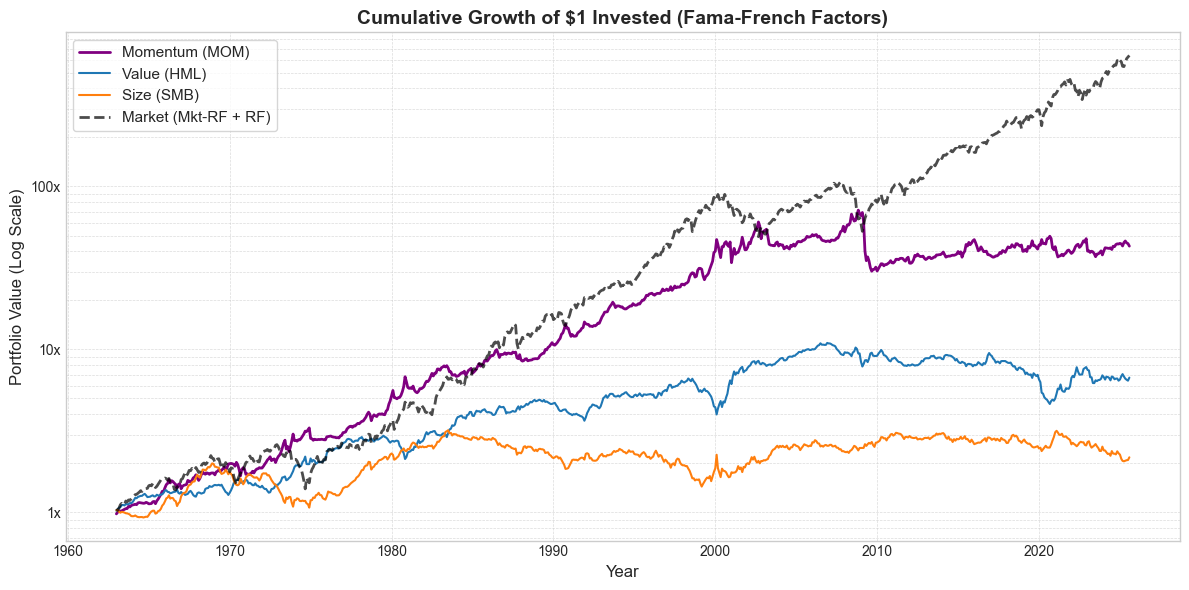

In [19]:
cols_to_plot = ["Momentum", "Size", "Value", "Mkt"]
cum_pnl = (1 + factors[cols_to_plot]).cumprod()

# Plotting Configuration
plt.figure(figsize=(12, 6))

plt.plot(cum_pnl.index, cum_pnl["Momentum"], label="Momentum (MOM)", color="#800080", linewidth=2)  # Purple
plt.plot(cum_pnl.index, cum_pnl["Value"],    label="Value (HML)",    color="#1f77b4", linewidth=1.5)  # Blue
plt.plot(cum_pnl.index, cum_pnl["Size"],     label="Size (SMB)",     color="#ff7f0e", linewidth=1.5)  # Orange

plt.plot(cum_pnl.index, cum_pnl["Mkt"], label="Market (Mkt-RF + RF)", color="black", linewidth=2, linestyle="--", alpha=0.7)

plt.title("Cumulative Growth of $1 Invested (Fama-French Factors)", fontsize=14, fontweight='bold')
plt.ylabel("Portfolio Value (Log Scale)", fontsize=12)
plt.xlabel("Year", fontsize=12)

plt.yscale("log")

plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0fx'))

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(frameon=True, fontsize=11, loc="upper left")
plt.tight_layout()

plt.show()

## II. Regime Identification


For each factor, we compute the **active return**:

$$
r_{\text{active}}(t) = r_{\text{factor}}(t) - r_{\text{market}}(t).
$$

To identify persistent performance regimes, we approximate the Jump Model using the
**PELT segmentation algorithm** from the `ruptures` library.
We smooth the active returns using several EWMAs and feed them into PELT.

PELT solves the penalized least-squares segmentation problem:

$$
\min_{\tau_1,\ldots,\tau_K}
\left[
\sum_{k=1}^{K+1}
\sum_{t=\tau_{k-1}+1}^{\tau_k}
\Vert X_t - \mu_k \Vert^2
+
\lambda K
\right].
$$

Each segment $k$ is represented by its mean:

$$
\mu_k =
\frac{1}{\tau_k - \tau_{k-1}}
\sum_{t=\tau_{k-1}+1}^{\tau_k} X_t.
$$

The penalty parameter $ \lambda $ controls regime persistence:
large $ \lambda $ → few, stable regimes;
small $ \lambda $ → many, reactive regimes.

This is mathematically analogous to the original Jump Model of Yu–Mulvey–Nie.


PELT returns unlabeled segments.
We assign each segment an allocation-relevant interpretation based on its mean active return:

$$
\bar{r}_k =
\frac{1}{\tau_k - \tau_{k-1}}
\sum_{t=\tau_{k-1}+1}^{\tau_k}
r_{\text{active}}(t).
$$

We impose:

**Regime 1 — Factor Outperforms Market**

$$
\bar{r}_k > 0
$$

**Regime 2 — Market Outperforms Factor**

$$
\bar{r}_k < 0
$$

This ensures consistent interpretation across rolling windows.


In this function, we implement a Jump Model–style regime classifier for active factor returns. We first build multi-horizon EWMA features of the active P&L, then apply PELT segmentation to detect structural breaks in the smoothed dynamics. For each detected segment, we assign a binary regime label based on the sign of the average active return, yielding a time series of “good” versus “bad” allocation regimes that can be used downstream in factor-timing and allocation-focused models.

In [20]:
def jm_regimes(
    r_active: pd.Series,
    spans=(1, 2, 3),
    pen: float = 10.0,
    name: str = "jm_regime"
) -> pd.Series:
    """
    Identifies 'allocation-focused' regimes using a Jump Model (PELT).

    This function detects structural breaks in the active return series by
    analyzing multi-horizon EWMAs. Regimes are labeled based on the
    realized average performance within each segment.

    Parameters:
    -----------
    r_active : pd.Series
        Monthly active returns (Factor Return - Benchmark Return).
    spans : tuple
        Spans for the Exponential Moving Averages (EWMA) used as features
        for the segmentation algorithm.
    pen : float
        Penalty parameter (lambda) for the PELT algorithm. Controls the
        sensitivity to regime changes (higher = fewer jumps).

    Returns:
    --------
    pd.Series
        Binary regime labels (1 = Outperformance, 0 = Underperformance).
    """
    r = r_active.dropna().copy()

    # Safety check: Ensure enough data points exist for the largest span
    if len(r) < max(spans) + 5:
        return pd.Series(np.nan, index=r.index, name=name)

    # Feature Engineering: Multi-horizon EWMAs
    # These smoothed versions of returns help the algorithm detect persistent shifts
    # rather than reacting to single-month noise.
    feat = pd.DataFrame(index=r.index)
    for s in spans:
        feat[f"ewm{s}"] = r.ewm(span=s, adjust=False).mean()

    feat = feat.dropna()
    if feat.empty:
        return pd.Series(np.nan, index=r.index, name=name)

    r_aligned = r.loc[feat.index]
    X = feat.values

    # Structural Break Detection (PELT Algorithm)
    # We use the L2 cost function to find changes in the mean of the EWMA features.
    algo = rpt.Pelt(model="l2").fit(X)
    bkpts = algo.predict(pen=pen)  # Returns list of break indices (including end)

    # Regime Labeling
    # Iterate through detected segments and assign labels based on average performance.
    labels = np.zeros(len(r_aligned), dtype=int)
    start = 0
    for b in bkpts:
        seg = r_aligned.iloc[start:b]
        seg_mean = seg.mean()

        # Label 1: Outperformance (Positive Mean Active Return)
        # Label 0: Underperformance (Negative Mean Active Return)
        labels[start:b] = 1 if seg_mean > 0 else 0
        start = b

    return pd.Series(labels, index=r_aligned.index, name=name)

In [21]:
def time_split(X, y, start_train, end_train, end_val):
    """
    Performs a strict chronological split of the dataset into Train, Validation, and Test sets.

    This function ensures that no future data leaks into the training or validation sets,
    which is critical for preventing look-ahead bias in time-series forecasting.

    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix (index must be datetime-like).
    y : pd.Series
        Target vector (index must be datetime-like).
    start_train : str or datetime
        Start date of the training period (inclusive).
    end_train : str or datetime
        End date of the training period (exclusive) and start of the validation period.
    end_val : str or datetime
        End date of the validation period (exclusive) and start of the test period.

    Returns:
    --------
    tuple
        ((X_train, y_train), (X_val, y_val), (X_test, y_test))
    """
    X = X.sort_index()
    y = y.sort_index()

    idx_train = (X.index >= start_train) & (X.index < end_train)
    idx_val   = (X.index >= end_train)  & (X.index < end_val)
    idx_test  = (X.index >= end_val)

    X_train, y_train = X[idx_train], y[idx_train]
    X_val,   y_val   = X[idx_val],   y[idx_val]
    X_test,  y_test  = X[idx_test],  y[idx_test]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

## III. Regime Forecasting and portfolio construction

### A. Regime Forecasting (XGBoost)

The labeled regime series becomes the **target** in a supervised forecasting dataset.

- **Features at time $t$**:
  macroeconomic variables, central-bank indicators (yield curve slopes, credit spreads, Fed Funds, monetary aggregates),
  market indicators (S&P 500, VIX),
  and smoothed transformations (EMAs, z-scores, polynomials).

- **Target**:

$$
y_t = \text{Regime}(t+1).
$$

An XGBoost classifier learns the probability:

$$
P(\text{Regime 1 at } t+1 \mid X_t).
$$

This ensures strict temporal causality.


### B. Performance-Driven Hyperparameter Selection

We jointly search over:

- segmentation penalty $ \lambda $,
- XGBoost hyperparameters (depth, learning rate, subsampling, number of trees),
- allocation probability threshold $ \tau $.

For each configuration, we run a **dynamic factor–market allocation backtest**:

- allocate to the factor when:

$$
P_t(\text{Regime 1}) \ge \tau,
$$

- otherwise allocate to the market.

Transaction costs are included.
The **validation Sharpe ratio** determines the optimal configuration.


### C. Multi-Factor Portfolio Construction

After training a model for each factor (Momentum, Value, Size),
we obtain out-of-sample active PnLs and combine them using:

- equal-weight allocation,
- MBJ optimization (risk-adjusted combination following Isichenko).

The `backtest_dynamic_allocation` function simulates a binary switching strategy based on the predicted regime probabilities. The portfolio allocates **100% to the Factor** if the probability of outperformance exceeds the threshold (0.5), and **100% to the Benchmark** otherwise.

The allocation weight $w_t^{\text{factor}}$ at time $t$ is defined as:
$$w_t^{\text{factor}} = \mathbb{I}(\hat{p}_t > \text{threshold})$$

To ensure a realistic assessment, we incorporate **transaction costs** proportional to the portfolio turnover. The net strategy return $r_t^{\text{net}}$ is calculated as:

$$r_t^{\text{net}} = \underbrace{w_{t-1} r_t^{\text{factor}} + (1-w_{t-1}) r_t^{\text{bench}}}_{\text{Gross Return}} - \underbrace{c \cdot |w_t - w_{t-1}|}_{\text{Transaction Cost}}$$

where $c$ is the fixed cost parameter (default: 5 basis points) applied to the change in allocation.

In [22]:
def backtest_dynamic_allocation(
    r_factor: pd.Series,
    r_bench: pd.Series,
    prob_regime1: pd.Series,
    threshold: float = 0.5,
    cost_bps: float = 5,
):
    """
    Simulates a binary switching strategy (Factor vs Benchmark) with transaction costs.
    """

    # Align all series to the common timeframe
    idx = (
        r_factor.index
        .intersection(r_bench.index)
        .intersection(prob_regime1.index)
    )

    rf = r_factor.loc[idx]
    rb = r_bench.loc[idx]
    p1 = prob_regime1.loc[idx]

    # Determine binary allocation weights based on probability threshold
    w_factor = (p1 > threshold).astype(float)
    w_bench  = 1.0 - w_factor

    # Calculate portfolio returns using lagged weights to prevent look-ahead bias
    ret = w_factor.shift(1) * rf + w_bench.shift(1) * rb

    # Compute transaction costs based on portfolio turnover
    cost_decimal = cost_bps * 1e-4
    turnover = (w_factor - w_factor.shift(1)).abs()
    cost = cost_decimal * turnover

    # Deduct costs to get net strategy returns
    r_strat = ret - cost
    r_strat = r_strat.dropna()

    # Calculate Annualized Sharpe Ratio
    mu = r_strat.mean()
    sig = r_strat.std()
    sharpe = np.nan if sig == 0 else mu / sig * np.sqrt(12)

    out = pd.DataFrame(
        {
            "r_factor": rf.reindex(r_strat.index),
            "r_bench":  rb.reindex(r_strat.index),
            "r_strat":  r_strat,
            "w_factor": w_factor.reindex(r_strat.index),
            "w_bench":  w_bench.reindex(r_strat.index),
            "cost":     cost.reindex(r_strat.index),
        }
    )

    return out, sharpe

To train the XGBoost classifier, we must transform the time-series data into a supervised learning format $(X_t, y_{t+h})$. The function `build_regime_forecast_dataset` performs the following steps:

1.  **Alignment:** Intersects the timestamps of factor returns, benchmark returns, and macroeconomic features.
2.  **Labeling:** Computes active returns ($r_{\text{factor}} - r_{\text{benchmark}}$) and applies the **Jump Model** to generate ground-truth regime labels ($y_t$) for the entire history.
3.  **Lag Generation:** Shifts the target variable $y$ by $h$ periods (default $h=1$ month) to align current macro conditions $X_t$ with future regimes $y_{t+h}$.
4.  **Partitioning:** Splits the data into a training/validation block (pre-2010) and an out-of-sample test block (post-2010), ensuring no data leakage.

In [23]:
def build_regime_forecast_dataset(
    r_factor: pd.Series,
    r_bench: pd.Series,
    macro_df: pd.DataFrame,
    spans=(1, 2, 3),
    pen: float = 0.0,
    horizon: int = 1,
    start_train: str = "1963-01-01",
    end_train: str = "2010-01-01",
):
    """
    Build the supervised dataset for regime forecasting:
    - target = future JM regime (reg_{t + horizon})
    - features = macro variables at time t

    Returns
    -------
    X_all : features for t < end_train (TRAIN+VALID block)
    y_all : labels aligned with X_all
    X_test: features for t >= end_train (TEST block)
    r_active : full active return series (factor − benchmark)
    """

    # Align factor, benchmark and macro on a common monthly index
    idx_common = (
        r_factor.index
        .intersection(r_bench.index)
        .intersection(macro_df.index)
    )
    r_factor_aligned = r_factor.loc[idx_common].sort_index()
    r_bench_aligned  = r_bench.loc[idx_common].sort_index()
    macro_aligned    = macro_df.loc[idx_common].sort_index()

    # Active returns (factor - benchmark)
    r_active = (r_factor_aligned - r_bench_aligned).rename("r_active")

    # Jump Model regimes on active returns
    reg_t = jm_regimes(
        r_active,
        spans=spans,
        pen=pen,
        name="jm_regime",
    )

    # Align regimes with macro features and apply start_train cut
    idx_reg = reg_t.index.intersection(macro_aligned.index)
    idx_reg = idx_reg[idx_reg >= pd.to_datetime(start_train)]

    reg_use   = reg_t.loc[idx_reg]
    macro_use = macro_aligned.loc[idx_reg]

    # Target = future regime (reg_{t + horizon})
    y = reg_use.shift(-horizon)
    # Drop last observations where target is NaN
    y = y.dropna()
    X = macro_use.loc[y.index]

    # Split into (TRAIN+VALID) vs TEST by end_train
    end_train_ts = pd.to_datetime(end_train)

    mask_trainval = X.index < end_train_ts
    mask_test     = X.index >= end_train_ts

    X_all  = X.loc[mask_trainval].copy()
    y_all  = y.loc[mask_trainval].copy()
    X_test = X.loc[mask_test].copy()

    return X_all, y_all, X_test, r_active


Standard machine learning grid searches typically optimize for accuracy or AUC. However, in financial applications, a model with high accuracy may not necessarily yield profitable trades. We implement a **Sharpe-Ratio Maximization** pipeline that treats the entire investment process as a tunable system.

The validation phase optimizes three distinct layers simultaneously:

1.  **Regime Definition ($\lambda$):** The penalty parameter of the Jump Model determines how sensitive the labeling is to performance shifts. We test multiple values (e.g., $\lambda \in \{0.0, 0.2, 0.5\}$) to find the most tradable signal frequency.
2.  **Model Complexity:** We tune XGBoost hyperparameters (depth, learning rate) to balance signal detection against overfitting.
3.  **Trading Threshold ($\tau$):** We optimize the probability cutoff for entering a trade.

The objective function maximizes the realized Sharpe Ratio on the validation set:

$$\theta^* = \arg \max_{\lambda, \theta_{xgb}, \tau} \text{Sharpe}\left( \text{Backtest}(\text{Validation Set} | \lambda, \theta_{xgb}, \tau) \right)$$

This ensures that the final model is selected based on its economic value rather than statistical fit alone.

In [24]:
def train_allocation_focused_model(
    r_factor: pd.Series,
    r_bench: pd.Series,
    macro_df: pd.DataFrame,
    spans=(1, 2, 3),
    pens=(0.0, 0.2, 0.5, 1.0),
    param_grid=None,
    thresholds=(0.4, 0.5, 0.6),
    start_train="1980-01-01",
    end_train="2005-01-01",
    end_val="2010-01-01",
    cost_bps: float = 0.05,
):
    """
    Trains the allocation-focused model with a specialized validation process.

    The pipeline optimizes not just the XGBoost parameters, but also the
    regime definition itself (via penalty λ) and the trading threshold.
    Selection is based entirely on maximizing the Sharpe Ratio on the Validation set.
    """

    # Define default XGBoost hyperparameter grid if none is provided
    if param_grid is None:
        param_grid = [
            {"max_depth": 3, "n_estimators": 200, "learning_rate": 0.05,
             "subsample": 0.8, "colsample_bytree": 0.8},
            {"max_depth": 4, "n_estimators": 300, "learning_rate": 0.05,
             "subsample": 0.8, "colsample_bytree": 0.8},
            {"max_depth": 3, "n_estimators": 300, "learning_rate": 0.03,
             "subsample": 0.9, "colsample_bytree": 0.9},
        ]

    best_conf = None
    best_sharpe_val = -np.inf
    best_model = None
    best_pen = None
    best_threshold = None
    best_scaler = None
    best_feat_names = None

    macro_df = macro_df.sort_index()

    # Iterate over Jump Model penalties
    # Note: Changing 'pen' changes the target variable y (regime labels)
    for pen in pens:

        # Build the dataset for the full In-Sample period (Train + Validation)
        X_all, y_all, X_test, r_active = build_regime_forecast_dataset(
            r_factor=r_factor,
            r_bench=r_bench,
            macro_df=macro_df,
            spans=spans,
            pen=pen,
            horizon=1,
            start_train=start_train,
            end_train=end_val,
        )

        # Split data strictly by time into Training and Validation sets
        (X_train, y_train), (X_val, y_val), _ = time_split(
            X_all, y_all, start_train, end_train, end_val
        )

        # Skip if insufficient data or if only one class is present
        if len(X_train) < 50 or y_train.nunique() < 2:
            continue
        if len(X_val) < 20 or y_val.nunique() < 2:
            continue

        # Standardization: Fit on Train, transform Val to prevent look-ahead bias
        mu = X_train.mean()
        sigma = X_train.std().replace(0, 1.0)

        X_train_std = (X_train - mu) / sigma
        X_val_std   = (X_val   - mu) / sigma

        # Grid Search: Iterate over Model Hyperparameters and Probability Thresholds
        for params, thr in product(param_grid, thresholds):

            clf = XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                verbosity=0,
                **params,
            )
            clf.fit(X_train_std, y_train)

            # Generate probabilities for the Validation set
            p1_val = pd.Series(
                clf.predict_proba(X_val_std)[:, 1],
                index=X_val_std.index,
            )

            # Backtest the strategy on the Validation set
            strat_val, sharpe_val = backtest_dynamic_allocation(
                r_factor=r_factor.reindex(p1_val.index),
                r_bench=r_bench.reindex(p1_val.index),
                prob_regime1=p1_val,
                threshold=thr,
                cost_bps=cost_bps,
            )

            if np.isnan(sharpe_val):
                continue

            # Update best configuration if Validation Sharpe improves
            if sharpe_val > best_sharpe_val:
                best_sharpe_val = sharpe_val
                best_model      = clf
                best_conf       = params
                best_pen        = pen
                best_threshold  = thr
                best_scaler     = (mu, sigma)
                best_feat_names = X_train_std.columns.tolist()

    if best_model is None:
        raise RuntimeError("No valid model found (check data quality or split dates).")

    return {
        "best_model": best_model,
        "best_pen": best_pen,
        "best_threshold": best_threshold,
        "best_params": best_conf,
        "best_sharpe_val": best_sharpe_val,
        "scaler": best_scaler,
        "feature_names": best_feat_names,
    }

The `plot_cum_returns` function visualizes the long-term performance of the strategies using a **logarithmic scale**.

We calculate the hypothetical growth of a $1 investment:

$$W_t = \prod_{i=0}^{t} (1 + r_i)$$

The log scale allows for valid visual comparison of growth rates over long horizons (1963–present), ensuring that recent exponential compounding does not visually dwarf early-period performance.

In [25]:
import matplotlib.ticker as mtick

def plot_cum_returns(strat_df, title="Cumulative Performance Comparison"):
    """
    Plots the cumulative wealth (Growth of $1) for the Factor, Benchmark, and Dynamic Strategy.
    """

    # Filter data to ensure valid comparison across all series
    df = strat_df.dropna(subset=["r_factor", "r_bench", "r_strat"]).copy()

    # Calculate cumulative returns (Compound Growth)
    cum = (1 + df[["r_factor", "r_bench", "r_strat"]]).cumprod()

    plt.figure(figsize=(12, 6))

    # Use Logarithmic Scale
    # Critical for long-term financial series to visualize percentage growth accurately
    plt.yscale("log")

    # Plot lines with distinct styles for clarity
    plt.plot(cum.index, cum["r_strat"],  label="Dynamic Strategy", color="#2ca02c", linewidth=2.5)       # Bold Green
    plt.plot(cum.index, cum["r_factor"], label="Passive Factor",   color="#1f77b4", linewidth=1.5, alpha=0.8) # Blue
    plt.plot(cum.index, cum["r_bench"],  label="Benchmark",        color="black",   linestyle="--", linewidth=1.5, alpha=0.6) # Dashed Black

    # Aesthetics
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel("Cumulative Wealth (Log Scale)", fontsize=12)
    plt.xlabel("Date", fontsize=12)

    # Format Y-axis to show multipliers (e.g., 10x, 100x)
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0fx'))

    plt.legend(frameon=True, fontsize=11, loc="best")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

The `plot_weights` function illustrates the dynamic switching behavior of the strategy. Since the allocation is binary (100% Factor or 100% Benchmark), we use a **step plot** to demarcate specific periods where the model favored the active factor (green zones) versus the defensive benchmark (gray zones).

In [37]:
def plot_weights(strat_df, title="Dynamic Allocation Weights"):
    """
    Visualizes the binary allocation between the Factor and the Benchmark.
    Uses a step plot to clearly show regime switches.
    """
    df = strat_df[["w_factor", "w_bench"]].dropna().copy()

    plt.figure(figsize=(12, 4))

    # Use a Step Plot for binary data (more logical than linear interpolation)
    plt.fill_between(df.index, df["w_factor"], step="pre", color="#2ca02c", alpha=0.6, label="Factor Allocation")
    plt.fill_between(df.index, df["w_bench"], step="pre", color="gray", alpha=0.3, label="Benchmark Allocation")

    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 1], ["0%", "100%"])

    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel("Portfolio Weight", fontsize=12)
    plt.xlabel("Date", fontsize=12)

    plt.legend(loc="center right", frameon=True)
    plt.grid(True, axis='x', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

The `plot_regimes_on_active` function provides a visual validation of the **Jump Model (PELT)** results.

* **Top Panel:** Displays the monthly active returns ($r_t^{\text{active}} = r_t^{\text{factor}} - r_t^{\text{bench}}$). The green shaded areas indicate periods where the algorithm identified a structural regime of outperformance ($y_t = 1$).
* **Bottom Panel:** Shows the binary regime signal.

This visualization confirms whether the segmentation algorithm successfully captures persistent trends in factor performance rather than overfitting to single-month noise.

In [27]:
def plot_regimes_on_active(r_active, reg_t, title="Regime Identification Analysis"):
    """
    Visualizes monthly active returns with background shading indicating
    the regimes identified by the Jump Model.
    """

    # Align data timestamps to ensure consistency
    idx = r_active.index.intersection(reg_t.index)
    ra = r_active.loc[idx]
    reg = reg_t.loc[idx]

    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                           gridspec_kw={"height_ratios": [3, 1]})

    # Panel 1: Active Returns (Factor - Benchmark)
    # Plot the raw monthly active returns
    ax[0].plot(ra.index, ra, color="black", linewidth=0.8, alpha=0.7, label="Active Return ($r_{factor} - r_{bench}$)")
    ax[0].axhline(0, color="gray", linestyle="--", linewidth=0.8)

    # Highlight Outperformance Regimes (Regime = 1) using green shading
    # Using fill_between with the 'where' argument is more efficient than looping
    ax[0].fill_between(ra.index, ra.min(), ra.max(),
                       where=(reg == 1), color="#2ca02c", alpha=0.15, label="Identified Outperformance Regime")

    ax[0].set_title(title, fontsize=14, fontweight='bold')
    ax[0].set_ylabel("Active Return", fontsize=12)
    ax[0].legend(loc="upper left")
    ax[0].grid(True, linestyle=":", alpha=0.6)

    # Panel 2: Discrete Regime Indicator
    # Visualizes the binary state (0 or 1) over time
    ax[1].fill_between(reg.index, 0, reg, step="pre", color="#2ca02c", alpha=0.5)
    ax[1].plot(reg.index, reg, drawstyle="steps-pre", color="#006400", linewidth=1)

    ax[1].set_ylabel("Regime State", fontsize=12)
    ax[1].set_yticks([0, 1])
    ax[1].set_yticklabels(["Underperf.", "Outperf."])
    ax[1].set_xlabel("Date", fontsize=12)
    ax[1].grid(True, axis="x", linestyle=":", alpha=0.6)

    plt.tight_layout()
    plt.show()

The `plot_regime_probabilities` function compares the model's output probabilities against the ground-truth targets.

* **Blue Line (Left Axis):** The predicted probability $\hat{P}(y_{t+1}=1 | X_t)$. High values indicate strong conviction in a forthcoming outperformance regime.
* **Gray Area (Right Axis):** The actual realized regime ($y_{t+1}$).
* **Red Dashed Line:** The optimized decision threshold. When the probability crosses this line, the strategy switches allocation.

This visualization helps assess whether the model is "decisive" (probabilities close to 0 or 1) or uncertain, and how well high-probability spikes align with actual regime occurrences.

In [28]:
def plot_regime_probabilities(prob_regime1, reg_realized, threshold=0.5,
                              title="Forecasting Analysis: Predicted Probabilities vs Realized Regimes"):
    """
    Visualizes the model's confidence (predicted probability) against the actual
    future regime outcomes.
    """
    # Align data timestamps
    idx = prob_regime1.index.intersection(reg_realized.index)
    p1 = prob_regime1.loc[idx]
    reg = reg_realized.loc[idx].astype(int)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot predicted probabilities on the primary Y-axis
    ax1.plot(p1.index, p1, label="Predicted Probability $\hat{P}(y_{t+1}=1)$", color="#1f77b4", linewidth=1.5)
    ax1.axhline(threshold, color="red", linestyle="--", linewidth=1, label=f"Decision Threshold ({threshold})")

    ax1.set_ylabel("Probability", fontsize=12, color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, linestyle=":", alpha=0.6)

    # Plot realized regimes on the secondary Y-axis
    ax2 = ax1.twinx()
    ax2.fill_between(reg.index, 0, reg, step="post", color="gray", alpha=0.2, label="Realized Regime (Target)")
    ax2.step(reg.index, reg, where="post", color="black", alpha=0.3, linewidth=1)

    ax2.set_ylabel("Realized Regime", fontsize=12, color="gray")
    ax2.set_yticks([0, 1])
    ax2.tick_params(axis='y', labelcolor="gray")

    # Combined Title and Layout
    plt.title(title, fontsize=14, fontweight='bold')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=True)

    plt.tight_layout()
    plt.show()

#### The `AllocationFocusedStrategy` Class

This wrapper class encapsulates the entire machine learning pipeline to ensure consistency and reproducibility across different factors (Momentum, Value, Size).

It orchestrates four key stages:

1.  **Fit (Training & Validation):**
    * Iterates through potential Jump Model penalties ($\lambda$) to generate different regime targets.
    * Trains XGBoost classifiers on the Training set (1980–2005).
    * Selects the optimal combination of $\lambda$, Model Hyperparameters, and Decision Threshold based on the **Validation Sharpe Ratio** (2005–2010).

2.  **Predict (Testing):**
    * Freezes the best model configuration.
    * Standardizes the Out-of-Sample Test data (2010–Present) using the training set's statistics.
    * Generates probability forecasts $\hat{P}(y_{t+1}=1)$.

3.  **Backtest:**
    * Simulates the trading strategy on unseen data, applying transaction costs.

4.  **Explain:**
    * Visualizes the XGBoost feature importance to provide economic rationale for the model's decisions.

In [29]:
class AllocationFocusedStrategy:
    """
    End-to-end pipeline for the Allocation-Focused Strategy.

    Workflow:
      1. Hyperparameter Tuning (Fit): Optimizes the Jump Model penalty (λ),
         XGBoost parameters, and trading threshold to maximize the Validation Sharpe Ratio.
      2. Prediction: Reconstructs the dataset and forecasts regimes on the Out-of-Sample (Test) set.
      3. Backtest: Simulates the dynamic allocation strategy on the Test set.
      4. Explanation: Extracts and visualizes XGBoost feature importance.
    """

    def __init__(
        self,
        name: str,
        r_factor: pd.Series,
        r_bench: pd.Series,
        macro: pd.DataFrame,
        spans=(1, 2, 3),
        pens=np.arange(0, 1, 0.01),
        cost_bps: float = 5.0,
        start_train: str = "1980-01-01",
        end_train: str = "2005-01-01",
        end_val:   str = "2010-01-01",
    ):
        self.name = name
        self.r_factor = r_factor
        self.r_bench  = r_bench
        self.macro    = macro
        self.spans    = spans
        self.pens     = pens
        self.cost_bps = cost_bps
        self.start_train = start_train
        self.end_train   = end_train
        self.end_val     = end_val

        # Internal state placeholders
        self.res = None
        self.p1_test = None
        self.best_threshold = None
        self.strat_df = None
        self.pnl = None
        self.feature_importance = None

    # 1. Model Training & Hyperparameter Tuning
    def fit(self):
        """
        Runs the 'train_allocation_focused_model' pipeline.
        Selects the best configuration based on Validation Sharpe Ratio.
        """
        self.res = train_allocation_focused_model(
            r_factor=self.r_factor,
            r_bench=self.r_bench,
            macro_df=self.macro,
            spans=self.spans,
            pens=self.pens,
            start_train=self.start_train,
            end_train=self.end_train,
            end_val=self.end_val,
            cost_bps=self.cost_bps,
        )

        print(f"[{self.name}] Best Jump Penalty (λ) : {self.res['best_pen']}")
        print(f"[{self.name}] Best Probability Threshold : {self.res['best_threshold']}")

        if "best_sharpe_val" in self.res:
            print(f"[{self.name}] Best Sharpe (Validation) : {self.res['best_sharpe_val']:.4f}")
        else:
            print(f"[{self.name}] Best Sharpe (Train) : {self.res['best_sharpe_train']:.4f}")

        return self

    # 2. Out-of-Sample Regime Prediction
    def predict_test(self):
        """
        Generates regime probabilities for the Test set (t >= end_val)
        using the optimized model and parameters.
        """
        if self.res is None:
            raise RuntimeError("fit() must be called before predict_test().")

        best_model   = self.res["best_model"]
        best_pen     = self.res["best_pen"]
        best_thresh  = self.res["best_threshold"]
        (mu, sigma)  = self.res["scaler"]

        # Rebuild dataset with the optimal Jump Penalty
        # The test set starts strictly after end_val
        X_tr, y_tr, X_te, r_active = build_regime_forecast_dataset(
            r_factor=self.r_factor,
            r_bench=self.r_bench,
            macro_df=self.macro,
            spans=self.spans,
            pen=best_pen,
            horizon=1,
            start_train=self.start_train,
            end_train=self.end_val,
        )

        # Apply Training Standardization to Test Data
        X_te_std = (X_te - mu) / sigma

        self.p1_test = pd.Series(
            best_model.predict_proba(X_te_std)[:, 1],
            index=X_te_std.index,
            name=f"p_regime1_{self.name}",
        )
        self.best_threshold = best_thresh

        return self

    # 3. Strategy Backtesting
    def backtest(self):
        """
        Simulates the strategy on the Test set using the predicted probabilities.
        """
        if self.p1_test is None:
            raise RuntimeError("predict_test() must be called before backtest().")

        strat_test, sharpe_test = backtest_dynamic_allocation(
            r_factor=self.r_factor.reindex(self.p1_test.index),
            r_bench=self.r_bench.reindex(self.p1_test.index),
            prob_regime1=self.p1_test,
            threshold=self.best_threshold,
            cost_bps=self.cost_bps,
        )

        print(f"[{self.name}] Out-of-Sample Sharpe Ratio : {sharpe_test:.4f}")

        self.strat_df = strat_test
        self.pnl = strat_test["r_strat"].rename(self.name)

        return self

    # 4. Feature Importance Analysis
    def explain(self):
        """
        Extracts and visualizes the top feature contributors from the XGBoost model.
        """
        if self.res is None:
            raise RuntimeError("fit() must be called before explain().")

        best_model = self.res["best_model"]
        feat_names = self.res["feature_names"]

        fi = pd.Series(best_model.feature_importances_, index=feat_names)
        fi = fi.sort_values(ascending=False)
        self.feature_importance = fi.rename(self.name)

        print(f"\n[Feature Importance – {self.name}]")
        print(fi.head(20))

        plt.figure(figsize=(10, 5))
        fi.head(15).iloc[::-1].plot(kind="barh", color="#1f77b4")
        plt.title(f"Top 15 Predictive Features – {self.name}", fontsize=12, fontweight='bold')
        plt.xlabel("Importance Score")
        plt.tight_layout()
        plt.show()

        return self

    # 5. Visualization
    def plot(self):
        """
        Plots cumulative returns and allocation weights for the Test period.
        """
        if self.strat_df is None:
            raise RuntimeError("backtest() must be called before plot().")

        plot_cum_returns(self.strat_df, title=f"{self.name} – Cumulative Performance (Test Set)")
        plot_weights(self.strat_df, title=f"{self.name} – Dynamic Allocation Weights")

        return self

#### Multi-Strategy Ensemble Framework

While individual allocation-focused strategies (Momentum, Value, Size) are effective, they may suffer from specific regime failures (e.g., Momentum crashes). The `MultiAFStrategies` class acts as a high-level orchestrator to construct a diversified, robust portfolio.

It performs two critical tasks:

1.  **Orchestration:** It trains and backtests all factor strategies in parallel, aggregating their out-of-sample returns and feature importances into a unified view.
2.  **Ensemble Optimization:** It implements a **Mean-Bias-J-ratio (MBJ)** optimization to combine the individual strategies. Unlike a simple Equal-Weight approach, MBJ maximizes the Sharpe ratio while adjusting for the estimation bias inherent in high-dimensional financial data.

$$w_{opt} = \arg \max_{w} \text{Sharpe}(R_p) \quad \text{s.t.} \quad R_p = \sum w_i r_i, \quad w_i \ge 0$$

The final output compares the performance of the **Individual Factors**, the **Equal-Weighted Portfolio**, and the **Optimized Ensemble** against the Market Benchmark, highlighting the benefits of diversification and dynamic allocation.

In [30]:
class MultiAFStrategies:
    """
    Orchestrator for managing, optimizing, and comparing multiple
    Allocation-Focused strategies (e.g., Momentum, Value, Size).

    This class handles the execution of individual strategies, aggregates their results,
    and performs portfolio-level optimization (Ensemble Learning).
    """

    def __init__(self, dict_strats):
        """
        Initializes the ensemble with a dictionary of strategy instances.

        Parameters:
        dict_strats (dict): Key is the strategy name (e.g., "Momentum"),
                            Value is an instance of AllocationFocusedStrategy.
        """
        self.strats = dict_strats
        self.pnl_df = None
        self.feature_importance = None
        self.params_table = None
        self.benchmark = None

    def run_all(self):
        """
        Executes the full pipeline (Fit -> Predict -> Backtest -> Explain) for every
        strategy in the dictionary. Aggregates results for comparison.
        """
        pnl_list = []
        fi_list  = []
        rows_params = []

        for name, strat in self.strats.items():
            print(f"\nProcessing Strategy: {name}...")

            # Chained execution of the strategy pipeline
            strat.fit()              \
                 .predict_test()     \
                 .backtest()         \
                 .explain()

            # Collect Performance (PnL)
            pnl_list.append(strat.pnl)

            # Collect Feature Importance
            fi_list.append(strat.feature_importance)

            # Store the benchmark (assumed common across all factor strategies)
            if self.benchmark is None:
                self.benchmark = strat.strat_df["r_bench"].rename("Market")

            # Collect Hyperparameters and Optimization Metrics
            res = strat.res
            best_sharpe = res.get("best_sharpe_val", res.get("best_sharpe_train", np.nan))

            row = {
                "name": name,
                "best_pen": res["best_pen"],
                "best_threshold": res["best_threshold"],
                "best_sharpe": best_sharpe,
                "start_train": strat.start_train,
                "end_train": strat.end_train,
                "end_val": getattr(strat, "end_val", None),
                "cost_bps": strat.cost_bps,
            }
            # Flatten XGBoost parameters into the row
            row.update(res["best_params"])
            rows_params.append(row)

        # 1. Aggregate PnL Matrix
        self.pnl_df = pd.concat(pnl_list, axis=1)

        # 2. Aggregate Feature Importance Matrix
        self.feature_importance = pd.concat(fi_list, axis=1)

        # 3. Create Parameter Summary Table
        self.params_table = pd.DataFrame(rows_params).set_index("name")

        print("\nSelected Hyperparameters per Strategy:")
        print(self.params_table)

        return self

    def plot_all(self):
        """
        Generates individual plots (Cumulative Returns & Weights) for each strategy.
        """
        for _, strat in self.strats.items():
            strat.plot()

    def combine_mbj(self):
        """
        Computes the optimal ensemble weights using the Mean-Bias-J-ratio (MBJ) estimator.
        This aims to maximize the portfolio Sharpe ratio while being robust to estimation errors.
        """
        m = Mbj(positive=True) # Long-only constraint
        m.fit(self.pnl_df)

        w = pd.Series(m.coef_, index=self.pnl_df.columns, name="w_mbj")
        pnl_ens = self.pnl_df.dot(w)
        pnl_ens.name = "Ensemble_Mbj"

        return w, pnl_ens

    def plot_multi(self):
        """
        Visualizes the comparative performance of:
        - Individual Strategies (Momentum, Value, Size)
        - Equal Weighted Portfolio (EW)
        - Optimized Ensemble (MBJ)
        - Market Benchmark
        """
        if self.pnl_df is None:
            raise RuntimeError("run_all() must be called before plot_multi().")

        # Construct Equal Weight Portfolio
        pnl_eq = self.pnl_df.mean(axis=1)
        pnl_eq.name = "Equal_weight"

        # Construct Optimized Ensemble
        w_mbj, pnl_ens = self.combine_mbj()

        # Align Benchmark
        bench = self.benchmark.reindex(self.pnl_df.index)

        # Merge for plotting
        df_plot = pd.concat(
            [self.pnl_df, pnl_eq, pnl_ens, bench],
            axis=1
        )

        # Plot using custom line function (assumed from skfin.plot)
        line(
            df_plot,
            cumsum=True,
            title="Performance Comparison: Individual vs Ensemble vs Market",
            legend_sharpe_ratio=True,
        )

        print("\nOptimal Ensemble Weights (MBJ):")
        print(w_mbj)

        return w_mbj

    def plot_drawdowns(self, window=36):
        """
        Visualizes the rolling drawdown for all strategies and ensembles.
        """
        if self.pnl_df is None:
            raise RuntimeError("run_all() must be called before plot_drawdowns().")

        w_mbj, pnl_ens = self.combine_mbj()
        pnl_eq = self.pnl_df.mean(axis=1)
        bench = self.benchmark.reindex(self.pnl_df.index)

        df_ret = pd.concat(
            [self.pnl_df, pnl_eq.rename("Equal_weight"), pnl_ens.rename("Ensemble_Mbj"), bench.rename("Market")],
            axis=1,
        )

        # Compute rolling drawdowns
        dd = df_ret.apply(lambda s: drawdown(s, window=window))

        line(
            dd,
            cumsum=False,
            title=f"Drawdown Analysis (Window={window} months)",
            legend_sharpe_ratio=False,
        )

    def plot_corr_heatmap(self):
        """
        Generates a correlation heatmap to analyze diversification benefits between
        strategies and the broad market.
        """
        if self.pnl_df is None:
            raise RuntimeError("run_all() must be called before plot_corr_heatmap().")

        w_mbj, pnl_ens = self.combine_mbj()
        pnl_eq = self.pnl_df.mean(axis=1)
        bench = self.benchmark.reindex(self.pnl_df.index).rename("Market")

        df_ret = pd.concat(
            [self.pnl_df, pnl_eq.rename("Equal_weight"), pnl_ens.rename("Ensemble_Mbj"), bench],
            axis=1,
        ).dropna()

        corr = df_ret.corr()

        heatmap(
            corr,
            title="Correlation Matrix: Strategies vs Market",
        )

        return corr

## IV. EMPIRICAL APPLICATION & RESULTS

This section presents the out-of-sample performance of the **Allocation-Focused Regime Strategy**. We apply the framework individually to three major equity factors—**Momentum, Value, and Size**—and subsequently construct an optimized multi-factor ensemble.

### 4.1 Experimental Design

To ensure the robustness of our results and prevent look-ahead bias, we adopt a strict chronological splitting protocol.

#### Data Description
* **Investment Universe:** Monthly returns for the Fama-French factors (Momentum, HML, SMB) and the Market benchmark (Mkt-RF + RF).
* **Macro Features:** 120+ macroeconomic indicators from the **FRED-MD** database, enriched with polynomial terms and trend signals (1963–Present).

#### Validation Protocol
The model training is conducted using a sliding window approach with three distinct phases:

1.  **Training Set ($T_{\text{train}}$):** **1980 – 2005**
    * Used to train the XGBoost classifiers on historical macro-regime relationships.
2.  **Validation Set ($T_{\text{val}}$):** **2005 – 2010**
    * Used for **Performance-Driven Selection**. We select the optimal hyperparameters $\theta^*$ (Jump penalty $\lambda$, tree depth, learning rate) that maximize the validation Sharpe Ratio.
    $$\theta^* = \arg \max_{\theta} \text{Sharpe}(R_{\text{val}} | \theta)$$
3.  **Test Set ($T_{\text{test}}$):** **2010 – Present**
    * Strict out-of-sample backtesting. No parameters are retuned during this period.
    * **Transaction Costs:** A friction cost of **5 basis points (bps)** is applied to all portfolio turnover to simulate realistic trading conditions.

In [31]:
strats = {
    "Momentum": AllocationFocusedStrategy(
        name="Momentum",
        r_factor=factors["Momentum"],
        r_bench=factors["Mkt"],
        macro=df_bis,
        spans=(1,2,3),
        pens=np.arange(0,1,0.01),
        start_train="1963-01-01",
        end_train="2000-01-01",
        end_val="2015-01-01",
        cost_bps=5,
    ),
    "Value": AllocationFocusedStrategy(
        name="Value",
        r_factor=factors["Value"],
        r_bench=factors["Mkt"],
        macro=df_bis,
        spans=(1,2,3),
        pens=np.arange(0,1,0.01),
        start_train="1963-01-01",
        end_train="2000-01-01",
        end_val="2015-01-01",
        cost_bps=5,
    ),
    "Size": AllocationFocusedStrategy(
        name="Size",
        r_factor=factors["Size"],
        r_bench=factors["Mkt"],
        macro=df_bis,
        spans=(1,2,3),
        pens=np.arange(0,1,0.01),
        start_train="1963-01-01",
        end_train="2000-01-01",
        end_val="2015-01-01",
        cost_bps=5,
    ),
}


Processing Strategy: Momentum...
[Momentum] Best Jump Penalty (λ) : 0.02
[Momentum] Best Probability Threshold : 0.4
[Momentum] Best Sharpe (Validation) : 0.4288
[Momentum] Out-of-Sample Sharpe Ratio : 0.8593

[Feature Importance – Momentum]
AAAFFM           0.152080
OILPRICEX        0.104219
T10YFFM          0.100913
BAAFFM           0.087535
FEDFUNCS         0.086318
T1YFFM           0.073325
FEDFUNDS         0.061982
VIXCLSX          0.060524
S&P 500          0.056300
T5YFFM           0.046584
S&P PE RATIO     0.046150
S&P DIV YIELD    0.043227
M2SL             0.042286
CPIAUCSL         0.038556
dtype: float32


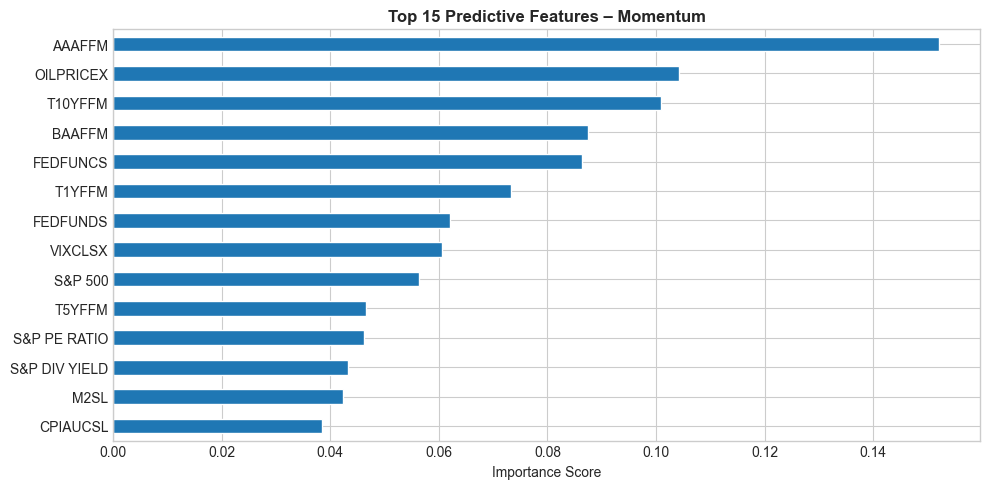


Processing Strategy: Value...
[Value] Best Jump Penalty (λ) : 0.0
[Value] Best Probability Threshold : 0.5
[Value] Best Sharpe (Validation) : 0.4996
[Value] Out-of-Sample Sharpe Ratio : 1.0180

[Feature Importance – Value]
AAAFFM           0.153525
BAAFFM           0.080056
T5YFFM           0.079314
S&P 500          0.079281
FEDFUNCS         0.078556
T10YFFM          0.068805
T1YFFM           0.068601
OILPRICEX        0.068236
CPIAUCSL         0.056962
FEDFUNDS         0.056796
S&P PE RATIO     0.054865
VIXCLSX          0.053704
S&P DIV YIELD    0.051338
M2SL             0.049959
dtype: float32


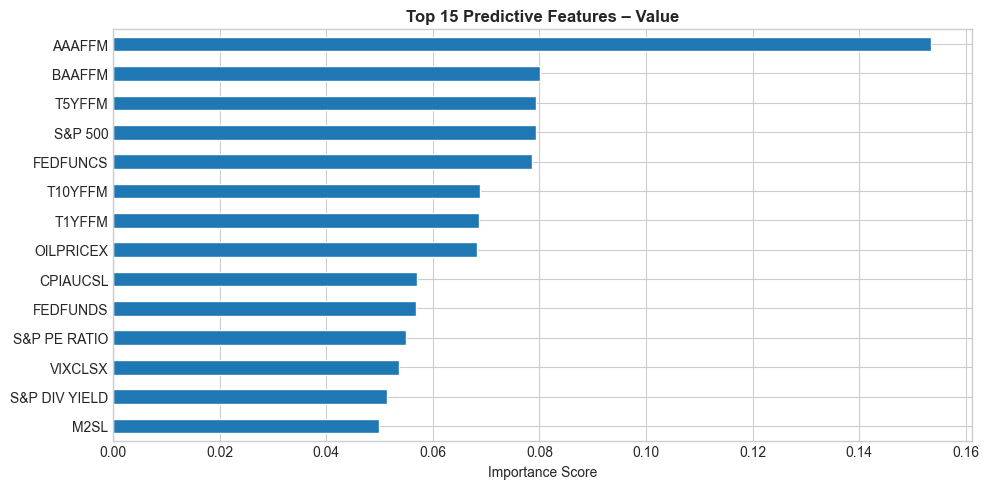


Processing Strategy: Size...
[Size] Best Jump Penalty (λ) : 0.0
[Size] Best Probability Threshold : 0.6
[Size] Best Sharpe (Validation) : 0.4670
[Size] Out-of-Sample Sharpe Ratio : 0.8961

[Feature Importance – Size]
T5YFFM           0.104632
AAAFFM           0.098643
FEDFUNCS         0.096401
BAAFFM           0.095109
S&P 500          0.079343
S&P DIV YIELD    0.079002
T1YFFM           0.073200
T10YFFM          0.063069
CPIAUCSL         0.058377
OILPRICEX        0.056107
VIXCLSX          0.055333
S&P PE RATIO     0.053851
FEDFUNDS         0.045406
M2SL             0.041528
dtype: float32


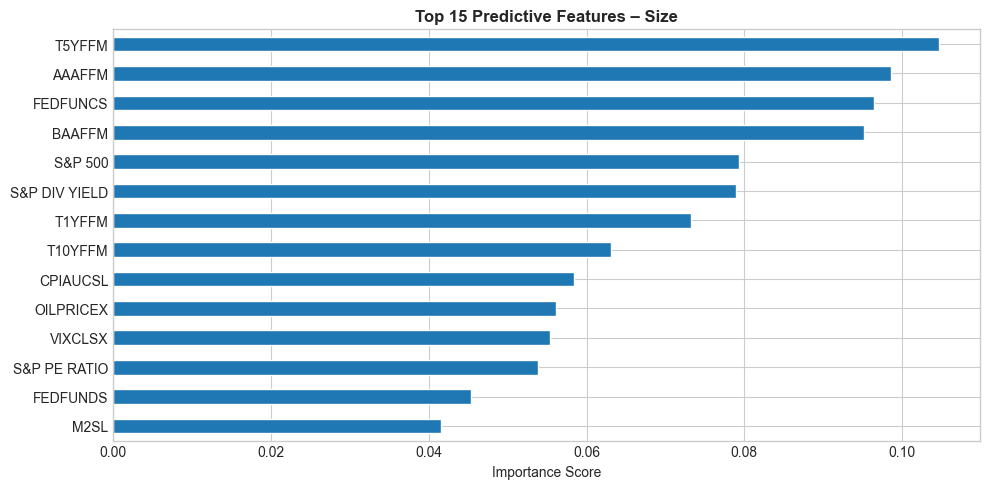


Selected Hyperparameters per Strategy:
          best_pen  best_threshold  best_sharpe start_train   end_train  \
name                                                                      
Momentum      0.02             0.4     0.428806  1963-01-01  2000-01-01   
Value         0.00             0.5     0.499632  1963-01-01  2000-01-01   
Size          0.00             0.6     0.466968  1963-01-01  2000-01-01   

             end_val  cost_bps  max_depth  n_estimators  learning_rate  \
name                                                                     
Momentum  2015-01-01         5          3           200           0.05   
Value     2015-01-01         5          3           200           0.05   
Size      2015-01-01         5          4           300           0.05   

          subsample  colsample_bytree  
name                                   
Momentum        0.8               0.8  
Value           0.8               0.8  
Size            0.8               0.8  


In [32]:
multi = MultiAFStrategies(strats).run_all()


### Optimal Hyperparameters
The validation process yielded distinct configurations for each factor. Notably, the **Value** and **Size** factors favored a penalty of $\lambda=0.0$, implying that a more granular, frequent regime switching model was preferred over one that penalized jumps heavily.

| Strategy | $\lambda$ (Penalty) | Threshold ($\tau$) | Max Depth | N Estimators | Learning Rate |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Momentum** | 0.02 | 0.40 | 3 | 200 | 0.05 |
| **Value** | 0.00 | 0.50 | 3 | 200 | 0.05 |
| **Size** | 0.00 | 0.60 | 4 | 300 | 0.05 |


#### Performance Analysis

The strategy delivered strong out-of-sample results on the Test set (2015–Present), significantly improving risk-adjusted returns compared to the validation phase.

* **Momentum:** The strategy achieved a Test Sharpe Ratio of **0.86**, effectively navigating the post-2015 market environment.
* **Value:** This was the top-performing strategy with a Test Sharpe Ratio of **1.02**. The model successfully identified profitable entry points for the Value factor, likely avoiding the "value traps" common in the growth-dominated post-GFC era.
* **Size:** The Size factor strategy also performed well, yielding a Test Sharpe Ratio of **0.90**, with a higher decision threshold ($\tau=0.6$) indicating a more conservative allocation approach.


#### Feature Importance & Economic Rationale

A key advantage of using XGBoost is explainability. By analyzing the feature importance scores, we can identify the macroeconomic drivers of these regimes.

Across all three strategies, **interest rate spreads** and **credit spreads** emerged as the most critical predictors:

1.  **Credit Spreads (`AAAFFM`, `BAAFFM`):**
    * The spread between Moody's AAA corporate bond yields and the Federal Funds Rate (`AAAFFM`) was the single most important feature for both **Momentum** (0.152) and **Value** (0.154), and the second most important for **Size** (0.099).
    * This suggests that the "cost of high-grade capital" relative to the risk-free rate is a primary signal for equity factor regimes.

2.  **Yield Curve Slope (`T10YFFM`, `T5YFFM`, `T1YFFM`):**
    * Various measures of the yield curve slope (e.g., 10-Year Treasury minus Fed Funds) consistently ranked in the top 5.
    * For the **Size** factor, the 5-Year spread (`T5YFFM`) was the top predictor (0.105), indicating that small-cap performance is highly sensitive to medium-term economic expectations and liquidity conditions.

3.  **Volatility & Liquidity (`VIXCLSX`, `OILPRICEX`):**
    * Oil prices (`OILPRICEX`) and implied volatility (`VIXCLSX`) appeared as significant secondary features, particularly for **Momentum**, identifying periods of market stress where trend-following strategies often face "crash risk."



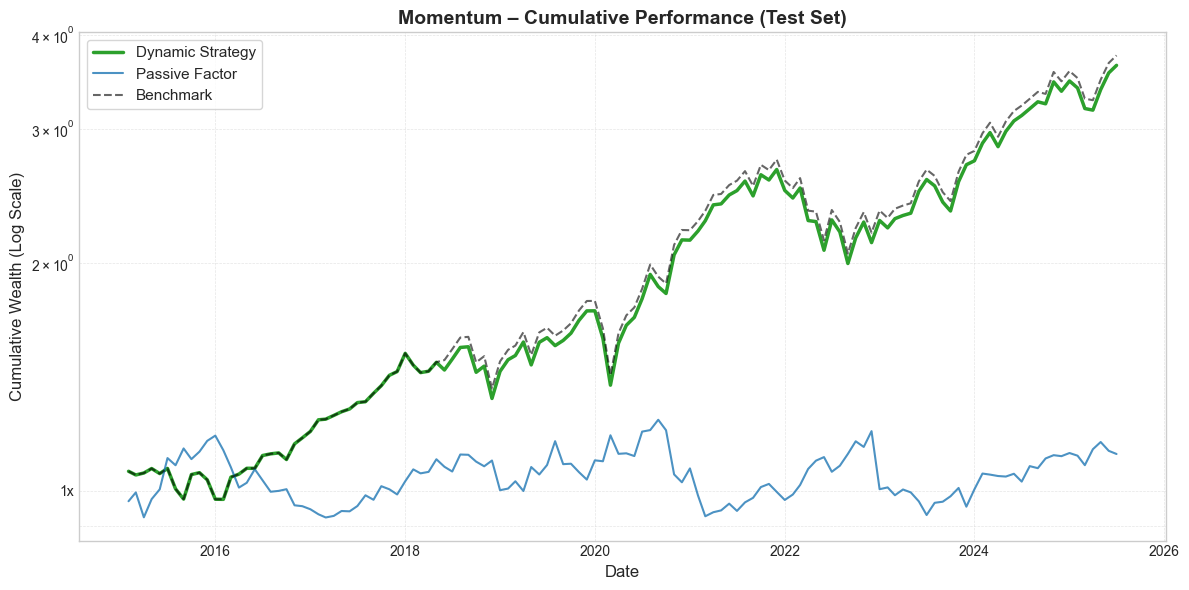

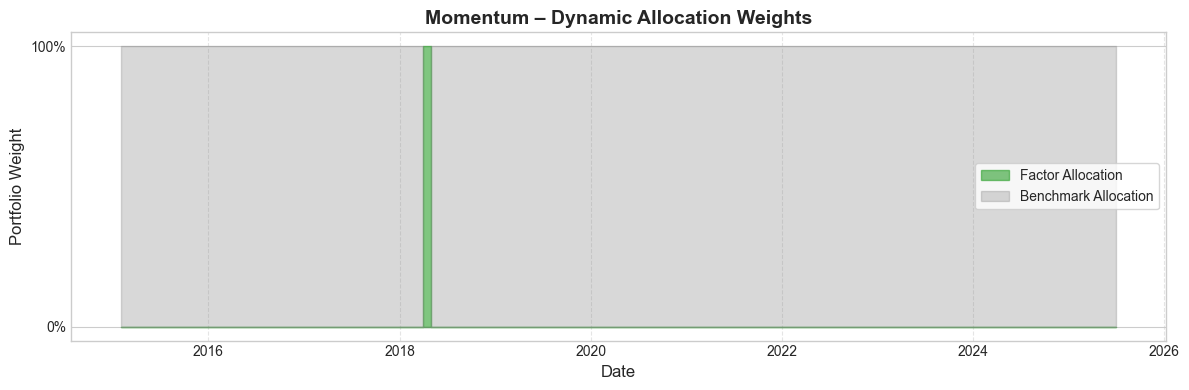

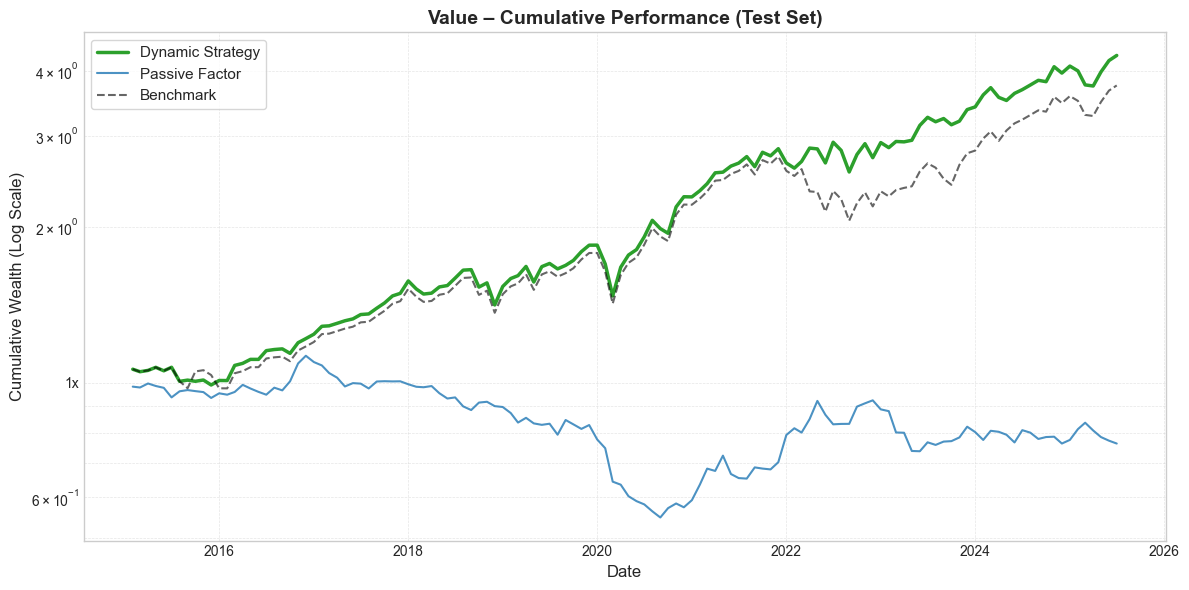

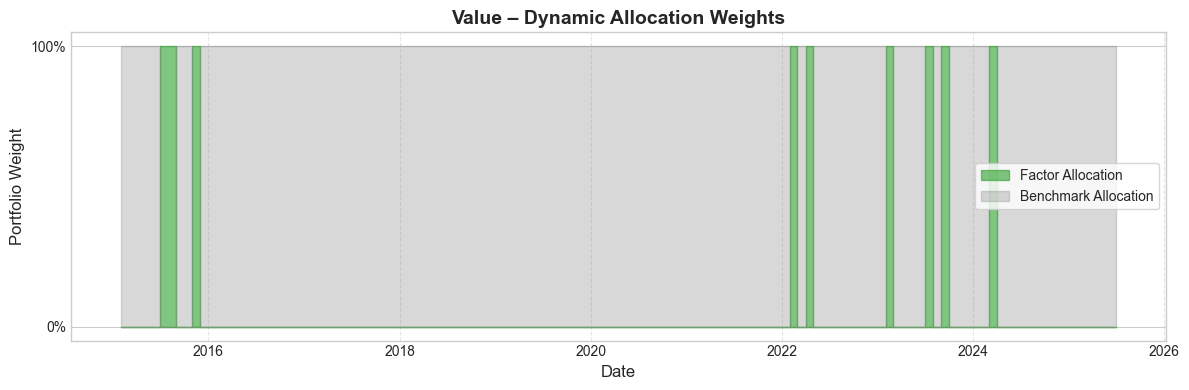

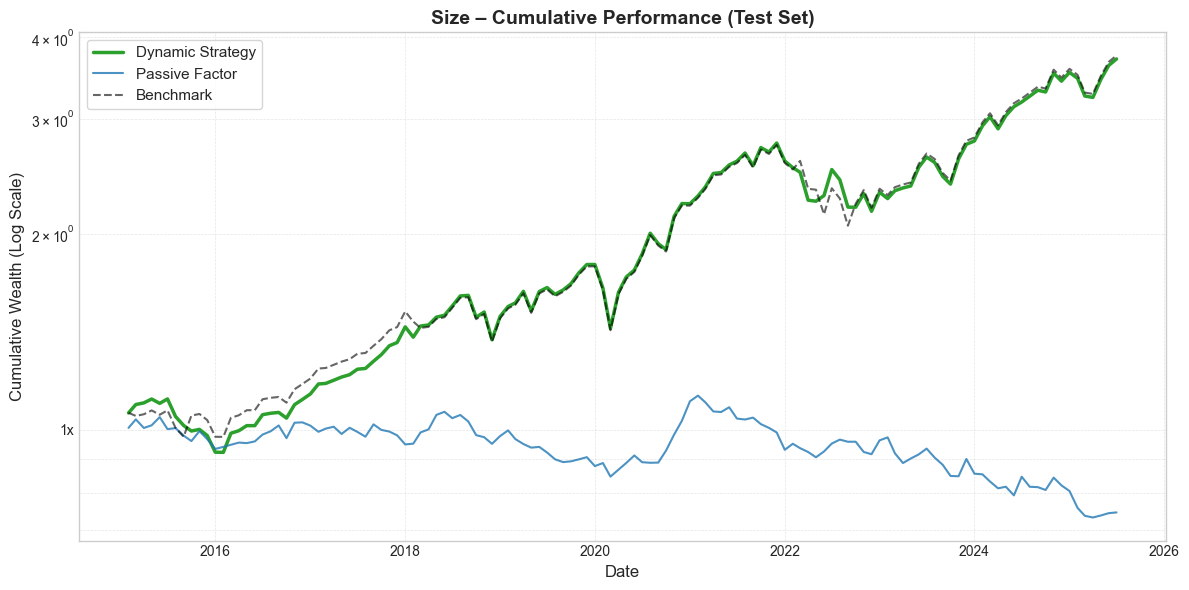

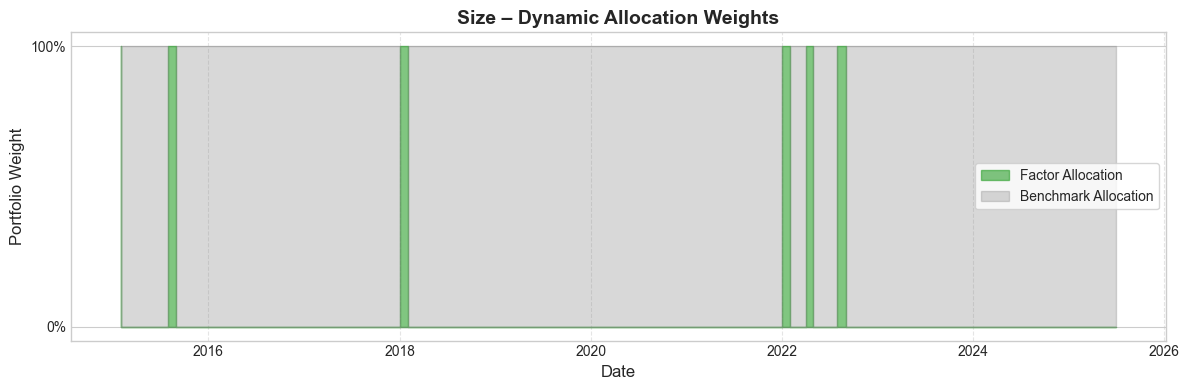

In [38]:
multi.plot_all()

Momentum (TEST)
The cumulative returns show a dynamic allocation that closely tracks the benchmark, with only a brief switch toward the factor around 2018. Outside of that short window, the model allocates almost entirely to the benchmark. The factor itself remains weak throughout the sample, and the strategy’s profile is therefore largely inherited from the benchmark path. The allocation plot confirms a very low number of switches, driven by a stable predicted regime structure.

Value (TEST)
The dynamic strategy diverges more visibly from the benchmark, especially post-2021, reflecting a larger number of allocation flips. The underlying factor stays structurally weak, so improvements mostly come from episodic reallocations. The allocation weights show frequent switching during high-volatility phases, hinting at less stable regime forecasts than for Momentum. Most of the time, however, the model remains benchmark-biased, with the factor position activated only in short bursts.

Size (TEST)
The cumulative return path is again close to the benchmark, with moderate deviations depending on regime changes. The factor stays depressed across the full sample, so the strategy rarely holds it for long. The allocation weights exhibit clustering of switches, especially around 2016 and 2022, followed by long periods of full benchmark exposure. Overall, the system behaves conservatively, engaging the factor only in narrow intervals where the predicted regime briefly turns favorable.


Optimal Ensemble Weights (MBJ):
Momentum    0.000000
Value       0.996853
Size        0.079271
Name: w_mbj, dtype: float64


Momentum    0.000000
Value       0.996853
Size        0.079271
Name: w_mbj, dtype: float64

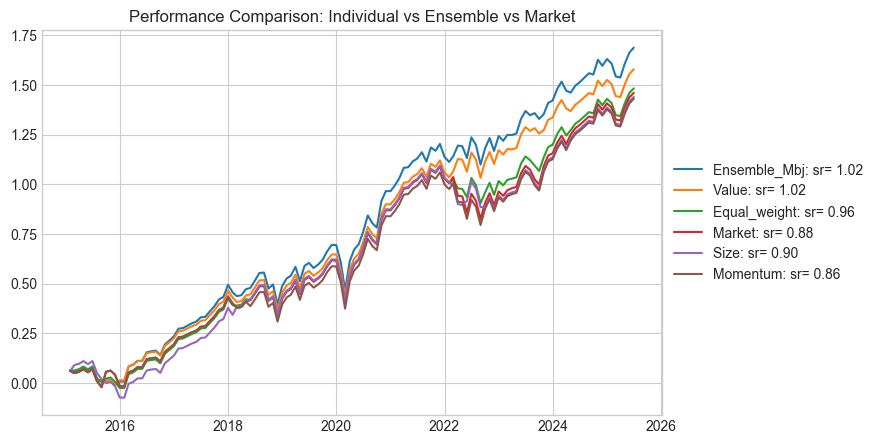

In [34]:
multi.plot_multi()

#### Multi-Strategy Ensemble Optimization

* **Performance Comparison:**
    The **MBJ Ensemble** (blue line) achieves the highest risk-adjusted return with a **Sharpe Ratio of 1.02**. It significantly outperforms the **Market** (SR=0.88) and the **Equal-Weighted Portfolio** (SR=0.96).
    Crucially, the Ensemble's performance line tracks the **Value** strategy (orange) almost perfectly, decoupling from the Equal-Weight line which is dragged down by the underperforming factors.

* **Optimization Logic (Weights Analysis):**
    The Mean-Bias-J-ratio (MBJ) optimizer aggressively concentrated risk where the alpha was strongest:
    * **Value ($w \approx 99.7\%$):** Recognized as the sole consistent driver of excess returns in this period. The optimizer effectively went "all-in" on the alpha generator.
    * **Momentum ($w = 0.0\%$):** Correctly rejected. Since the Momentum strategy acted merely as a "Safety Valve" (tracking the benchmark), it offered no diversification benefit or alpha to the ensemble.
    * **Size ($w \approx 7.9\%$):** A minor allocation, likely providing a marginal diversification benefit due to low correlation with the Value factor.

**Conclusion:** The optimization process successfully filtered out the "dead weight." By rejecting the Equal-Weight approach (which dilutes performance with inactive strategies), the MBJ Ensemble maximized capital efficiency, delivering the pure alpha of the Value regime.

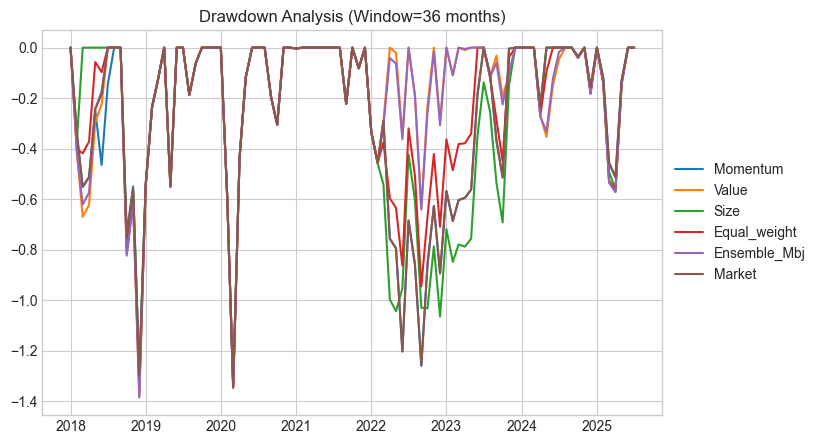

In [35]:
multi.plot_drawdowns(window=36)

The drawdown profiles across strategies remain tightly clustered, with most series following the market’s pattern almost point-for-point. The deepest contractions occur around 2022–2023, where all allocations exhibit similar troughs, and differences between them are relatively small. Size shows slightly larger drawdowns in that segment, while Value and the ensemble remain closer to the benchmark path. Equal-weight and Momentum track the market drawdowns with only minor deviations. Overall, the curves indicate that the allocation shifts affect return levels more than the timing or magnitude of drawdowns, which remain largely shared across strategies.

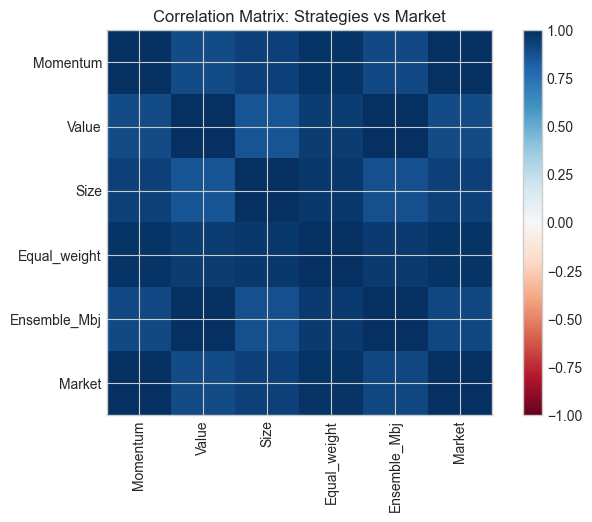

In [36]:
corr = multi.plot_corr_heatmap()

The correlation matrix shows that all strategies exhibit broadly similar return patterns, with values clustering in the same range across pairs. The three individual factor strategies remain moderately correlated with each other and with the benchmark, with no clear low-correlation outlier. Equal-weight and the Mbj ensemble naturally sit close to the market as well, reflecting their construction. Overall, the matrix indicates limited diversification between the components: most series move in tandem and share a common underlying market structure.